# Rede Neural Convolucional com Dataset CIFAR-10

Grupo: Lucas Eduardo, Ian Marcony, Paulo Ricardo, Gustavo Araújo, Marcos Costa, Miguel Ângelo, Valéria Ribeiro, Kaique Olegar.

### CIFAR 10
O CIFAR-10 é um conjunto de dados de classificação de imagens que consiste em 60.000 imagens coloridas divididas em 10 classes. Cada imagem tem uma resolução de 32x32 pixels.
O dataset é dividido em um conjunto de treino com 50.000 imagens e um conjunto de teste com 10.000 imagens.
O problema proposto pelo CIFAR-10 é uma tarefa de classificação de imagens. O objetivo é treinar um modelo que possa identificar corretamente a classe de uma imagem entre as 10 possíveis. Isso envolve várias etapas:
1) Pré-processamento das Imagens
2) Normalização: Ajustar os valores dos pixels para uma faixa adequada (geralmente 0 a 1).
3) Augmentação de Dados: Aplicar técnicas como rotação, corte, e espelhamento para aumentar a variedade das imagens de treino e melhorar a generalização do modelo.
4) Construção do Modelo:Utilização de redes neurais convolucionais (CNNs), que são particularmente eficazes para tarefas de visão computacional devido à sua capacidade de capturar características espaciais e hierárquicas das imagens.
5) Treinamento: Ajuste dos pesos do modelo utilizando algoritmos de otimização (como SGD, Adam) para minimizar a função de perda, geralmente a entropia cruzada para problemas de classificação.
6) Avaliação:  Medir a precisão do modelo no conjunto de teste para verificar sua capacidade de generalização.

## Importação de bibliotecas necessárias

In [1]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 724.1 kB/s eta 0:00:0031m1.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 5.4 MB/s eta 0:00:005.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.5 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 8.7 MB/s eta 0:00:0011.1 MB/s eta 0:00:01


In [2]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 5.2 MB/s eta 0:00:00m eta 0:00:010:00:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 10.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 9.0 MB/s eta 0:00:00m eta 0:00:010:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.2 MB/s eta 0:00:000:00:010:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install keras_cv

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 3.6 MB/s eta 0:00:003.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.7 MB/s eta 0:00:0031m11.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 7.7 MB/s eta 0:00:0031m152.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 8.6 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.1 MB/s eta 0:00:004.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 8.

In [5]:
!pip install scikeras

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install scikit-learn==1.2.2

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 7.5 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.


In [8]:
#Importando libs essenciais
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from keras.layers import BatchNormalization
from keras.layers  import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier
from keras_cv.layers import Grayscale

## Separando dados para treinamentos

De início, é realizada a separação de dados de treinamento. 

### Leitura de dataset

In [10]:
#Separando dados para treinamentos
seed = 10
np.random.seed(seed)
(X_treinamento, y_treinamento),(X_teste, y_teste) =  cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 70s 0us/step


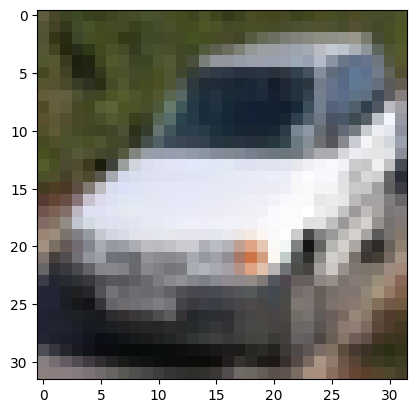

In [ ]:
#Mostrando imagem
plt.imshow(X_treinamento[46])

### Conversão das imagens em escala de cinza

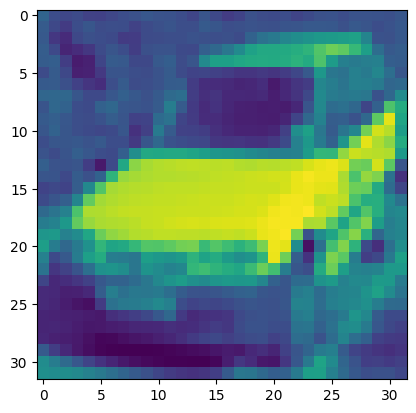

In [11]:
# Convertendo imagens
to_grayscale = Grayscale()
previsores_treinamento = to_grayscale(X_treinamento)
previsores_teste = to_grayscale(X_teste)
previsores_treinamento = np.array(previsores_treinamento)
previsores_teste = np.array(previsores_teste)
plt.imshow(previsores_treinamento[46])

In [16]:
print(previsores_treinamento.shape)
print(previsores_teste.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)


### Tratando dados de pixels para uma escala de 0-1

In [12]:
#Tratando dados de pixels para uma escala de 0-1
previsores_treinamento /= 255
previsores_teste /= 255

### Convertendo classes

In [13]:
#Convertendo classes
classe_treinamento = to_categorical(y_treinamento, 10)
classe_teste = to_categorical(y_teste, 10)

## Criação de Augumentation

Augmentation é uma técnica que visa aumentar a diversidade dos dados de treinamento sem a necessidade de coletar mais dados. Isso é feito aplicando transformações às imagens existentes, gerando variações que ajudam o modelo a generalizar melhor e reduzir o overfitting.

In [14]:
# Augumentation
gerador_treinamento = ImageDataGenerator(rotation_range=7,
                                         horizontal_flip= True,
                                         shear_range = 0.2,
                                         height_shift_range = 0.07,
                                         zoom_range=0.2)

gerador_teste = ImageDataGenerator()

base_treinamento = gerador_treinamento.flow(previsores_treinamento, classe_treinamento, batch_size= 128)
base_teste = gerador_teste.flow(previsores_teste, classe_teste, batch_size= 128)

In [20]:
print(base_treinamento.x.shape)
print(base_teste.x.shape)
print(classe_treinamento.shape)
print(classe_teste.shape)
print(previsores_treinamento.shape)
print(previsores_teste.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)
(50000, 10)
(10000, 10)
(50000, 32, 32, 1)
(10000, 32, 32, 1)


## Criação da Rede Neural Convolucional

In [15]:
#Iniciar rede convulacional
def criarRede(optimizer='adam', activation='relu'):
  classificador = Sequential()
  classificador.add(Conv2D(32, (4,4), input_shape=(32,32,1),
                          activation = "relu")) #Criação do mapa de características
  classificador.add(BatchNormalization()) #Normalização dos dados
  classificador.add(MaxPooling2D(pool_size=(2,2))) #Realização do MaxPooling para pegar as principais características


  classificador.add(Conv2D(32, (3,3),strides=2, activation = "relu")) #Criação do mapa de características
  classificador.add(BatchNormalization()) #Normalização dos dados
  classificador.add(MaxPooling2D(pool_size=(2,2))) #Realização do MaxPooling para pegar as principais características


  classificador.add(Flatten()) #Normalizar para uma entrada comum na rede neural densa
  classificador.add(Dense(units=128, activation = "relu" ))
  classificador.add(Dropout(0.2))
  classificador.add(Dense(units=256, activation = "relu" ))
  classificador.add(Dropout(0.2))
  classificador.add(Dense(units=10, activation = "softmax" ))
  classificador.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam', metrics = ['accuracy'])
  return classificador

In [22]:
# Labels do CIFAR 10
labels = 'airplane automobile bird cat deer dog frog horse ship truck'.upper().split(' ')
labels

['AIRPLANE',
 'AUTOMOBILE',
 'BIRD',
 'CAT',
 'DEER',
 'DOG',
 'FROG',
 'HORSE',
 'SHIP',
 'TRUCK']

## Inicialização de treinamentos e testes

### Instanciando rede neural

In [23]:
classificador = criarRede()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Usando dados originais em escala de cinza

In [ ]:
# Usando dados originais em escala de cinza
classificador.fit(previsores_treinamento, classe_treinamento, batch_size= 128, epochs = 20)
precisao = classificador.evaluate(previsores_teste, classe_teste)
print(f'Precisão usando dados originais em escala de cinza: {precisao}')

Epoch 1/20
391/391 [==============================] - 9s 6ms/step - loss: 1.7199 - accuracy: 0.3826
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 1.3709 - accuracy: 0.5154
Epoch 3/20
391/391 [==============================] - 2s 5ms/step - loss: 1.2174 - accuracy: 0.5730
Epoch 4/20
391/391 [==============================] - 2s 5ms/step - loss: 1.1190 - accuracy: 0.6077
Epoch 5/20
391/391 [==============================] - 2s 6ms/step - loss: 1.0453 - accuracy: 0.6362
Epoch 6/20
391/391 [==============================] - 2s 6ms/step - loss: 0.9917 - accuracy: 0.6528
Epoch 7/20
391/391 [==============================] - 2s 5ms/step - loss: 0.9449 - accuracy: 0.6695
Epoch 8/20
391/391 [==============================] - 2s 5ms/step - loss: 0.9098 - accuracy: 0.6829
Epoch 9/20
391/391 [==============================] - 2s 5ms/step - loss: 0.8708 - accuracy: 0.6939
Epoch 10/20
391/391 [==============================] - 2s 5ms/step - loss: 0.8435 - accuracy: 0.7051

1/1 [==============================] - 0s 194ms/step
Previsão: 0 Label Prevista: AIRPLANE
Classe real: 0 Label Real: AIRPLANE
Resultado: ACERTOU


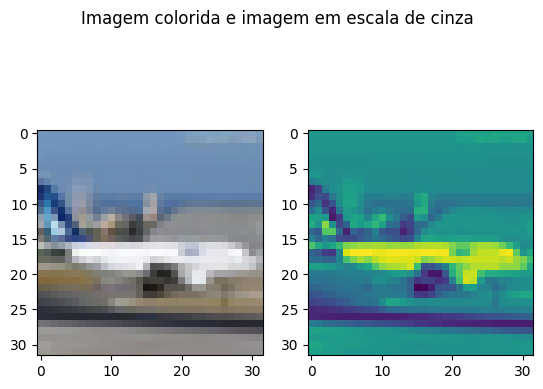

In [ ]:
index =  90
imagem_teste = np.expand_dims(previsores_teste[index], axis =0)
previsao = classificador.predict(imagem_teste)
previsao = np.argmax(previsao, axis=-1)[0]
classe_real = preds_classes = np.argmax(classe_teste[index], axis=-1)
fig, axs = plt.subplots(1,2)
fig.suptitle('Imagem colorida e imagem em escala de cinza')
axs[0].imshow(X_teste[index])
axs[1].imshow(previsores_teste[index])
resultado = 'ACERTOU' if previsao==classe_real else 'ERROU'
print(f'Previsão: {previsao} Label Prevista: {labels[previsao]}\nClasse real: {classe_real} Label Real: {labels[classe_real]}\nResultado: {resultado}')

### Validação Cruzada

Na validação cruzada, todo o conjunto de 60 mil imagens (de treinamento e de teste) é concatenada e o resultado é dividido aleatoriamente em k folds de tamanho aproximadamente igual. Em seguida, em cada iteração realizada k vezes, um dos k folds é usado como conjunto de validação, e os k-1 folds restantes são usados como conjunto de treinamento.
As métricas de desempenho (acurácia, precisão, recall) são calculadas para cada uma das k iterações e posteriormente dispostas em um gráfico


In [24]:
previsores = np.concatenate((previsores_treinamento, previsores_teste))
classes = np.concatenate((classe_treinamento, classe_teste))

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

precisoes = []
recalls = []
acuracias = []

for k, (train_index, test_index) in enumerate(kfold.split(previsores, np.argmax(classes, axis=1))):
    print("=-"*6 + f"Fold: {k+1}" + "-="*6)
    X_train, X_val = previsores[train_index], previsores[test_index]
    y_train, y_val = classes[train_index], classes[test_index]

    classificador = criarRede()
    classificador.fit(gerador_treinamento.flow(X_train, y_train, batch_size=128),
                      epochs=15, validation_data=(X_val, y_val), verbose=0)

    y_pred = classificador.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_val_classes = np.argmax(y_val, axis=1)

    precisao = precision_score(y_val_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_val_classes, y_pred_classes, average='weighted')
    acuracia = accuracy_score(y_val_classes, y_pred_classes)

    precisoes.append(precisao)
    recalls.append(recall)
    acuracias.append(acuracia)

print("Resultados da Validação Cruzada:")
print("Precisões:", precisoes)
print("Recalls:", recalls)
print("Acurácias:", acuracias)
print("Média da Precisão:", np.mean(precisoes))
print("Média de Recalls:", np.mean(recalls))
print("Média da Acurácia:", np.mean(acuracias))

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 4-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 5-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Resultados da Validação Cruzada:
Precisões: [0.636938885819176, 0.6680666564450526, 0.6155609821671608, 0.6607229008718294, 0.6569730866194988]
Recalls: [0.5725833333333333, 0.66075, 0.52525, 0.6555, 0.65]
Acurácias: [0.5725833333333333, 0.66075, 0.52525, 0.6555, 0.65]
Média da Precisão: 0.6476525023845435
Média de Recalls: 0.6128166666666666
Média da Acurácia: 0.6128166666666666


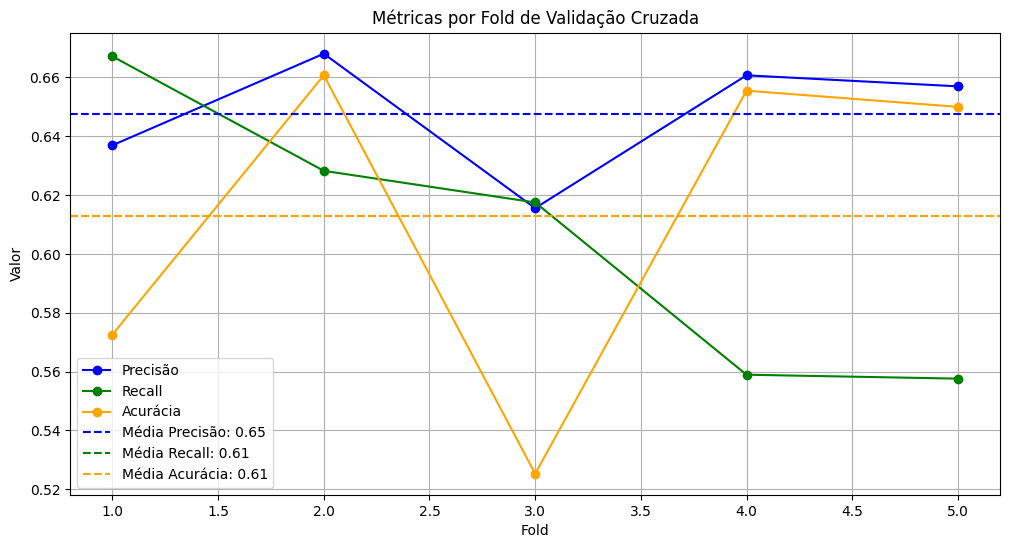

In [25]:
plt.figure(figsize=(12, 6))
folds = range(1, len(precisoes) + 1)

plt.plot(folds, precisoes, marker='o', linestyle='-', color='blue', label='Precisão')
plt.plot(folds, revocacoes, marker='o', linestyle='-', color='green', label='Recall')
plt.plot(folds, acuracias, marker='o', linestyle='-', color='orange', label='Acurácia')

plt.axhline(y=np.mean(precisoes), color='blue', linestyle='--', label=f'Média Precisão: {np.mean(precisoes):.2f}')
plt.axhline(y=np.mean(recalls), color='green', linestyle='--', label=f'Média Recall: {np.mean(recalls):.2f}')
plt.axhline(y=np.mean(acuracias), color='orange', linestyle='--', label=f'Média Acurácia: {np.mean(acuracias):.2f}')

plt.xlabel('Fold')
plt.ylabel('Valor')
plt.title('Métricas por Fold de Validação Cruzada')
plt.legend()
plt.grid(True)

plt.show()

### Treinamento e teste com Augumentation

In [ ]:
classificador = criarRede()
classificador.fit(base_treinamento,
                  steps_per_epoch= base_treinamento.x.shape[0]/base_treinamento.batch_size,
                  epochs = 20,
                  validation_data=base_teste,
                  validation_steps=base_teste.x.shape[0]/base_teste.batch_size)
precisao = classificador.evaluate(base_teste.x, base_teste.y)
print(f'Precisão usando dados originais em escala de cinza: {precisao}')

Epoch 1/20
390/390 [==============================] - 19s 42ms/step - loss: 1.8011 - accuracy: 0.3533 - val_loss: 2.2139 - val_accuracy: 0.2419
Epoch 2/20
390/390 [==============================] - 16s 42ms/step - loss: 1.5303 - accuracy: 0.4591 - val_loss: 1.7576 - val_accuracy: 0.3992
Epoch 3/20
390/390 [==============================] - 17s 45ms/step - loss: 1.4069 - accuracy: 0.5055 - val_loss: 1.4803 - val_accuracy: 0.4793
Epoch 4/20
390/390 [==============================] - 16s 41ms/step - loss: 1.3266 - accuracy: 0.5344 - val_loss: 1.6548 - val_accuracy: 0.4549
Epoch 5/20
390/390 [==============================] - 16s 41ms/step - loss: 1.2622 - accuracy: 0.5611 - val_loss: 1.1611 - val_accuracy: 0.5963
Epoch 6/20
390/390 [==============================] - 16s 42ms/step - loss: 1.2104 - accuracy: 0.5742 - val_loss: 1.1096 - val_accuracy: 0.6131
Epoch 7/20
390/390 [==============================] - 18s 46ms/step - loss: 1.1761 - accuracy: 0.5893 - val_loss: 1.4411 - val_accuracy:

1/1 [==============================] - 0s 18ms/step
Previsão: 9 Label Prevista: TRUCK
Classe real: 9 Label Real: TRUCK
Resultado: ACERTOU


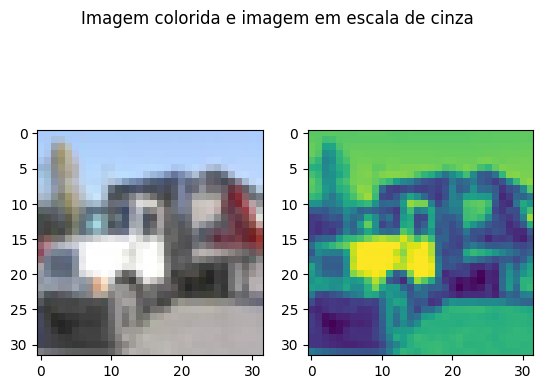

In [ ]:
index =  45
imagem_teste = np.expand_dims(previsores_teste[index], axis =0)
previsao = classificador.predict(imagem_teste)
previsao = np.argmax(previsao, axis=-1)[0]
classe_real = preds_classes = np.argmax(classe_teste[index], axis=-1)
fig, axs = plt.subplots(1,2)
fig.suptitle('Imagem colorida e imagem em escala de cinza')
axs[0].imshow(X_teste[index])
axs[1].imshow(previsores_teste[index])
resultado = 'ACERTOU' if previsao==classe_real else 'ERROU'
print(f'Previsão: {previsao} Label Prevista: {labels[previsao]}\nClasse real: {classe_real} Label Real: {labels[classe_real]}\nResultado: {resultado}')

# Busca em grade

Para observar as métricas de diferentes combinações de hiperparâmetros aplicados em um modelo, foi utilizada a busca em grade. Trata-se de uma técnica para encontrar os melhores hiperparâmetros para um modelo de aprendizado de máquina. Foram testados o seguintes parâmetros:
1) Número de Épocas: O número de vezes que o modelo vê todo o conjunto de dados durante o treinamento.
2) Tamanho do batch:  número de amostras que o modelo processa antes de atualizar seus pesos.
3) Otimizador:


In [26]:
# Parâmetros escolhiddos para ajustar
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [128, 256],
    'epochs': [10, 15]
}

In [27]:
!pip install scikeras
import scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/13.4 MB 144.2 kB/s eta 0:01:10
ERROR: Exception:
Traceback (most recent call last):
  File "/home/dialog/.local/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/home/dialog/.local/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "/home/dialog/.local/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/home/dialog/.local/lib/python3.10/site-packages/pip/_vendor/cachecontrol/filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
  File "/usr/lib/python3.10/http/client.py", line 466, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    retu

In [28]:
# Create KerasClassifier with the wrapper build_fn
classificador = KerasClassifier(build_fn=criarRede, verbose=0, activation='relu')

# Set up KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# Configure GridSearchCV
grid = GridSearchCV(estimator=classificador, param_grid=param_grid, scoring='accuracy', cv=kfold)

# Fit the model
grid_result = grid.fit(previsores_treinamento, classe_treinamento)

/home/dialog/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` 

NameError: name 'dados_teste' is not defined

In [30]:
score = grid.score(previsores_teste, classe_teste)
print(f'Performance no conjunto de teste: {score:.4f}')

# Exibir melhores parâmetros e resultados
print(f'Melhores parâmetros: {grid_result.best_params_}')
print(f'Melhor acurácia: {grid_result.best_score_:.4f}')

Performance no conjunto de teste: 0.6282
Melhores parâmetros: {'batch_size': 128, 'epochs': 15, 'optimizer': 'rmsprop'}
Melhor acurácia: 0.6279


In [31]:
# Exibindo os melhores parâmetros e a melhor precisão
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

Melhor: 0.627860 usando {'batch_size': 128, 'epochs': 15, 'optimizer': 'rmsprop'}


In [32]:
# Exiba os resultados de todas as combinações de parâmetros
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) com: %r" % (mean, std, param))

0.610940 (0.041141) com: {'batch_size': 128, 'epochs': 10, 'optimizer': 'adam'}
0.590460 (0.057199) com: {'batch_size': 128, 'epochs': 10, 'optimizer': 'rmsprop'}
0.617000 (0.052561) com: {'batch_size': 128, 'epochs': 15, 'optimizer': 'adam'}
0.627860 (0.020049) com: {'batch_size': 128, 'epochs': 15, 'optimizer': 'rmsprop'}
0.599200 (0.036789) com: {'batch_size': 256, 'epochs': 10, 'optimizer': 'adam'}
0.571480 (0.043318) com: {'batch_size': 256, 'epochs': 10, 'optimizer': 'rmsprop'}
0.607400 (0.076176) com: {'batch_size': 256, 'epochs': 15, 'optimizer': 'adam'}
0.625360 (0.031121) com: {'batch_size': 256, 'epochs': 15, 'optimizer': 'rmsprop'}


In [33]:
# Média dos resultados
media = means.mean()
std = stds.mean()

print(f"Acurácia média: {media}\nDesvio padrão médio: {std}")

Acurácia média: 0.6062125
Desvio padrão médio: 0.04479414262964007


In [40]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Média da Acurácia", "Desvio Padrão", "Parâmetros"]

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    table.add_row([f"{mean:.4f}", f"{std:.4f}", param])

print(table)

+-------------------+---------------+-----------------------------------------------------------+
| Média da Acurácia | Desvio Padrão |                         Parâmetros                        |
+-------------------+---------------+-----------------------------------------------------------+
|       0.6109      |     0.0411    |   {'batch_size': 128, 'epochs': 10, 'optimizer': 'adam'}  |
|       0.5905      |     0.0572    | {'batch_size': 128, 'epochs': 10, 'optimizer': 'rmsprop'} |
|       0.6170      |     0.0526    |   {'batch_size': 128, 'epochs': 15, 'optimizer': 'adam'}  |
|       0.6279      |     0.0200    | {'batch_size': 128, 'epochs': 15, 'optimizer': 'rmsprop'} |
|       0.5992      |     0.0368    |   {'batch_size': 256, 'epochs': 10, 'optimizer': 'adam'}  |
|       0.5715      |     0.0433    | {'batch_size': 256, 'epochs': 10, 'optimizer': 'rmsprop'} |
|       0.6074      |     0.0762    |   {'batch_size': 256, 'epochs': 15, 'optimizer': 'adam'}  |
|       0.6254      

<Figure size 1400x700 with 0 Axes>

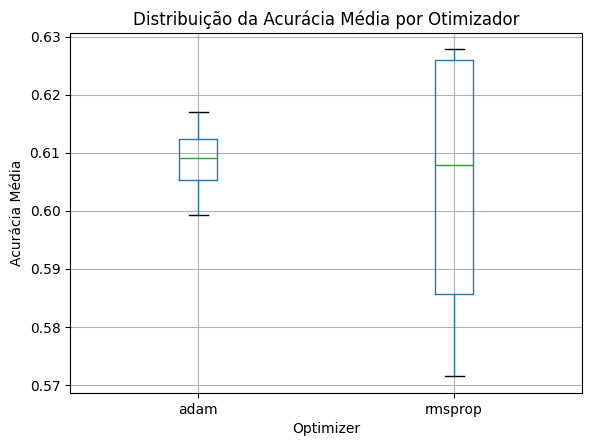

In [41]:
import pandas as pd
results = pd.DataFrame(grid_result.cv_results_)

# Boxplot para Distribuição das Métricas
plt.figure(figsize=(14, 7))
results.boxplot(column='mean_test_score', by='param_optimizer', grid=True)
plt.xlabel('Optimizer')
plt.ylabel('Acurácia Média')
plt.title('Distribuição da Acurácia Média por Otimizador')
plt.suptitle('')  # Remove the default title
plt.show()


# Gráficos

In [2]:
import matplotlib.pyplot as plt

In [ ]:
joined = list(zip(means, stds))
print(joined)
print("---")
joined = sorted(joined)


[(0.60854, 0.032058), (0.60346, 0.042699), (0.61698, 0.024757), (0.60866, 0.044798), (0.61112, 0.047558), (0.56418, 0.056226), (0.62024, 0.019505), (0.58946, 0.06743)]
---


Text(0.5, 1.0, 'Acurácia Média do Grid Search Ordenado')

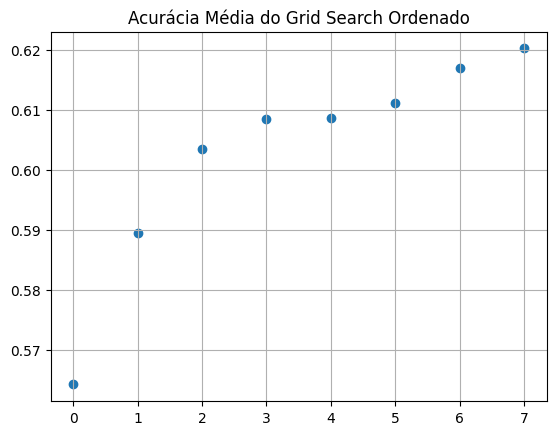

In [ ]:
plt.scatter(y = [i[0] for i in joined], x = [i for i in range(len(means))])
plt.grid()
plt.title("Acurácia Média do Grid Search Ordenado")

Text(0.5, 1.0, 'Desvio Padrão Médio do Grid Search')

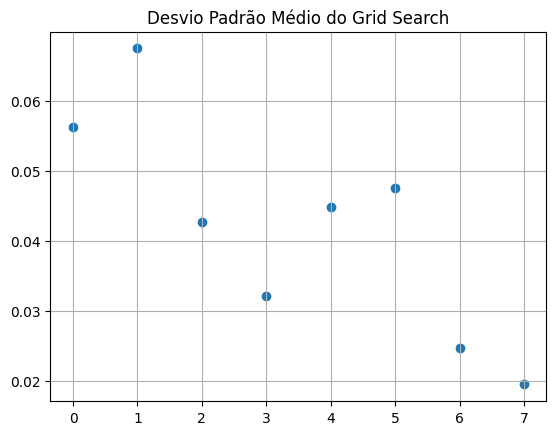

In [ ]:
plt.scatter(y = [i[1] for i in joined], x = [i for i in range(len(stds))])
plt.grid()
plt.title("Desvio Padrão Médio do Grid Search")